In [1]:
#https://github.com/anhvung/Capstone-Audio-Transcription/blob/whisper/whisper/whisper_intro.ipynb
#https://github.com/anhvung/Capstone-Audio-Transcription/blob/whisper/whisper/whisper_intro_noise.ipynb
#https://github.com/anhvung/Capstone-Audio-Transcription/blob/whisper/whisper/robust_noise.ipynb

In [2]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-2f3bfr5g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-2f3bfr5g
  Resolved https://github.com/openai/whisper.git to commit 9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d
  Preparing metadata (setup.py) ... done


In [3]:
#!pip install datasets transformers jiwer colorednoise

In [4]:
import utils
import transformers
import os
transformers.logging.set_verbosity_error()

In [5]:
# set paths for input/output
root = os.getcwd()
datasets_path = os.path.join(root, 'datasets')
predictions_path = os.path.join(root, 'predictions')
# create folders if they do not already exist
if not os.path.exists(datasets_path): os.makedirs(datasets_path)
if not os.path.exists(predictions_path): os.makedirs(predictions_path)

In [6]:
langs = ["te_in", "cmn_hans_cn", "ko_kr", "he_il"]
codes = {"te_in":'te', "cmn_hans_cn":'zh', "ko_kr":'ko', "he_il":'iw'}
datas = {}

In [7]:
from datasets import load_dataset

for lang in langs:
  datas[lang] = load_dataset('google/fleurs', lang, split='test')
  datas[lang] = datas[lang].remove_columns(['id', 'num_samples', 'path',
                                            'raw_transcription', 'gender',
                                            'lang_id', 'language', 'lang_group_id'])
  datas[lang] = datas[lang].rename_column('transcription', 'ground_truth')

Found cached dataset fleurs (/home/alexandriaguo/.cache/huggingface/datasets/google___fleurs/te_in/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)
Found cached dataset fleurs (/home/alexandriaguo/.cache/huggingface/datasets/google___fleurs/cmn_hans_cn/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)
Found cached dataset fleurs (/home/alexandriaguo/.cache/huggingface/datasets/google___fleurs/ko_kr/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)
Found cached dataset fleurs (/home/alexandriaguo/.cache/huggingface/datasets/google___fleurs/he_il/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)


In [8]:
for lang in langs:
    print(lang)
    print(datas[lang])

te_in
Dataset({
    features: ['audio', 'ground_truth'],
    num_rows: 472
})
cmn_hans_cn
Dataset({
    features: ['audio', 'ground_truth'],
    num_rows: 945
})
ko_kr
Dataset({
    features: ['audio', 'ground_truth'],
    num_rows: 382
})
he_il
Dataset({
    features: ['audio', 'ground_truth'],
    num_rows: 792
})


In [9]:
import whisper
import torch
import numpy as np
import pandas as pd
import torchaudio
import jiwer
from tqdm.notebook import tqdm

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [11]:
model = whisper.load_model('base')
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 71,825,920 parameters.


In [12]:
processor, model = utils.load_whisper("openai/whisper-base")

In [13]:
%%time
results = {}
for lang in langs:
    print("Start eval on ", lang)
    results[lang] = datas[lang].map(utils.map_to_pred_ml,
                                 fn_kwargs={"model": model, "processor": processor, "lang": codes[lang]},
                                 writer_batch_size=1000)
    
    print("Saving dataset...")
    results[lang].save_to_disk(utils.os.path.join(predictions_path, 'fleurs_' + lang + '_whisper_base'))

Start eval on  te_in


  0%|          | 0/472 [00:00<?, ?ex/s]

/opt/conda/lib/python3.7/site-packages/transformers/generation_utils.py:1301: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Saving dataset...
Start eval on  cmn_hans_cn


  0%|          | 0/945 [00:00<?, ?ex/s]

Saving dataset...
Start eval on  ko_kr


  0%|          | 0/382 [00:00<?, ?ex/s]

Saving dataset...
Start eval on  he_il


  0%|          | 0/792 [00:00<?, ?ex/s]

Saving dataset...
CPU times: user 33min 33s, sys: 9min 48s, total: 43min 22s
Wall time: 26min 44s


In [14]:
os.chdir(root)
!gsutil -m cp -r ./predictions/ gs://capstone_datasets/fleurs/test/whisper_base/ # removed -n to overwrite

Copying file://./predictions/fleurs_ko_kr_whisper_base/dataset_info.json [Content-Type=application/json]...
Copying file://./predictions/fleurs_ko_kr_whisper_base/state.json [Content-Type=application/json]...
Copying file://./predictions/fleurs_ko_kr_whisper_base/dataset.arrow [Content-Type=application/octet-stream]...
Copying file://./predictions/fleurs_ta_in_whisper_base/dataset_info.json [Content-Type=application/json]...
Copying file://./predictions/fleurs_ta_in_whisper_base/state.json [Content-Type=application/json]...
Copying file://./predictions/fleurs_ta_in_whisper_base/dataset.arrow [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https:/

In [27]:
import unicodedata
check = 3
print(results['ko_kr']['ground_truth'][:check])
print(results['ko_kr']['transcription'][:check])
print(jiwer.wer(results['ko_kr']['ground_truth'][check], results['ko_kr']['transcription'][check]))
print(jiwer.wer(unicodedata.normalize("NFKC", results['ko_kr']['ground_truth'][check]),
      results['ko_kr']['transcription'][check]))

['피라미드 사운드와 광선 쇼는 이 지역에서 어린이들의 흥미를 가장 많이 끌어들이는 것들 중 하나입니다', '더 전통적인 교회는 부활절 주간의 토요일 밤에 부활 철야제를 열며 여기에서 신도들이 종종 자정에 주의 부활을 축하합니다', '산을 둘러싸고 있는 맑고 아름다운 하늘밖에는 보이지 않는다 이 동굴 안에서는 바깥세상이 보이지도 들리지도 않는다']
['피라미드 사운드와 광선쇼는 이 지역에서 어린이들의 흥미를 가장 많이 끌어드리는 것들 중 하나입니다', '더 전통적인 교회는 부활절주간에 토요일 밤에 부활 처리하기를 열며 여기에서 신두들이 종종 자정의 주의 부활을 축하합니다', '산을 둘러싸고 있는 맑고 아름다운 하늘 바뀌는 보이지 않는다 이 동구란에서는 바깥 세상이 보이지도 들리지도 않는다']
1.0
0.0


In [16]:
print(results['cmn_hans_cn']['ground_truth'][:check])
print(results['cmn_hans_cn']['transcription'][:check])

['1940 年 8 月 15 日 盟 军 攻 入 法 国 南 部 这 次 进 攻 被 称 为 龙 骑 兵 行 动', '该 群 岛 位 于 南 极 半 岛 以 北 120 公 里 处 最 大 的 岛 屿 是 乔 治 国 王 岛 这 里 是 繁 星 村 villa las estrellas 的 定 居 点', '卷 心 菜 汁 的 颜 色 将 根 据 化 学 物 质 的 酸 碱 性 发 生 变 化']
['1940 年 8 月 15 日 蒙 軍 公 路 法 國 南 部 這 次 進 攻 被 稱 為 龍 旗 冰 晴 洞', '該 全 島 位 於 南 極 半 島 一 杯 120 公 里 處 最 大 的 島 嶼 是 橋 至 國 王 島 這 裡 是 凡 青 春 的 定 居 點', '卷 心 菜 之 的 颜 色 将 根 据 化 学 物 质 的 酸 检 性 发 生 变 化']


In [17]:
print(results['he_il']['ground_truth'][:check])
print(results['he_il']['transcription'][:check])

['בדרך כלל תמיד שומעים את קולות התיירים והמוכרים סיפור הקול והאור הוא ממש כמו ספר סיפורים', 'זו דרך חשובה להבדיל בין מספר פעלים ועצמים', 'הגובה המינימלי מתחת לגשר הוא 15 מטר הבנייה הסתיימה באוגוסט 2011 והוא נפתח לתנועה רק במרץ 2017']
['בדרך כלל תמיד שום עם את כלות התיירים ועמוקרים סיבור הכל והאור הוא ממש כמו סיבורים', 'זודר חשובה להבדיד במספר פעלים והצמין', 'הגובה מנימה למטחת לגשר הוא 50 הבנייה היסטיימא באוגוס 2 one רבו נפתח לתנוע רק במרצ 2 2']


In [18]:
print(results['te_in']['ground_truth'][:check])
print(results['te_in']['transcription'][:check])

['ర డవ సట\u200cల del potroక ఆధకయ లభ చన క డ ఈ సట\u200cల క డ 6 6క చర క నన తరవత ట బరక అనవరయ అయయ ద', 'హజరన వర స ఖయ ఎ త ఎకక వ ట saint peter is సకవరల జరగన అ తయకరయలన చ డడనక అ దరక సధయపడలద', 'కవల కనన సవలప బధల తపప కలపనక బ దల క డ స పరదయ బ దల వ ట నప ణయ కలగ ఉ టయ']
['10 個 ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potraku ndavasetlau del potra

In [33]:
# Helper for prediction data before WER
# Remove it after modification on datasets

# from whisper.normalizers import EnglishTextNormalizer
# normalizer = EnglishTextNormalizer()
#
def map_trans(batch):
    transcription = batch['transcription'][0]
    transcription = unicodedata.normalize("NFKC", batch['transcription'])
    batch['transcription'] = transcription
    return batch

In [31]:
type(predictions['ko_kr']['transcription'])

list

In [34]:
predictions = {}
for lang in langs:
    predictions[lang] = utils.load_from_disk(utils.os.path.join(predictions_path, 'fleurs_{}_whisper_base'.format(lang)))
    predictions[lang] = predictions[lang].map(map_trans)
    # predictions[lang].save_to_disk(utils.os.path.join(predictions_path, 'fleurs_' + lang + '_whisper_base'))
    print('WER: Whisper_base, {}:'.format(lang), utils.format_wer(predictions[lang]["ground_truth"], predictions[lang]["transcription"]), '%.')

  0%|          | 0/472 [00:00<?, ?ex/s]

WER: Whisper_base, te_in: 184.0 %.


  0%|          | 0/945 [00:00<?, ?ex/s]

WER: Whisper_base, cmn_hans_cn: 38.0 %.


  0%|          | 0/382 [00:00<?, ?ex/s]

WER: Whisper_base, ko_kr: 104.1 %.


  0%|          | 0/792 [00:00<?, ?ex/s]

WER: Whisper_base, he_il: 70.6 %.


__PREVIOUSLY:__ results on 11/3 run w/ incorrect normalization for Chinese. (also note, botched predictions/transcriptions for Tamil currently still saved to bucket, to be deleted)

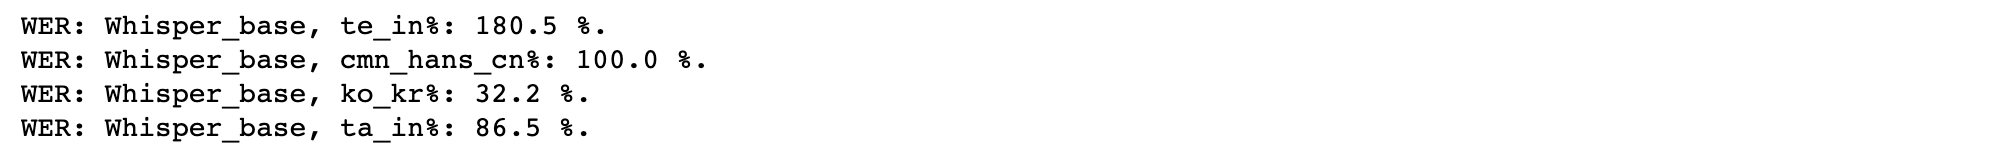

Compare expected WERs on Fleurs, as published for whisper-base:<br>
> Chinese: 34.1%<br>
> Korean: 27.8%<br>
> Hebrew: 61.7%<br>
> Telugu: 105.2%<br>